This playbook calculates de F1 Score, evaluation score and Confusion Matrix values for the fine-tuned models


In [7]:



import pickle
import os

out_dir = ""
block_size = 256
eval_batch_size = 16
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset


In [8]:
import  json
import logging
logger = logging.getLogger(__name__)
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 input_tokens,
                 input_ids,
                 label,

                 ):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.label=label


def convert_examples_to_features(js,tokenizer):
    #source
    code=' '.join(js['code'].split())
    code_tokens=tokenizer.tokenize(code)[:block_size-2]
    source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
    source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
    padding_length = block_size - len(source_ids)
    source_ids+=[tokenizer.pad_token_id]*padding_length
    return InputFeatures(source_tokens,source_ids,js['label'])

class TextDataset(Dataset):
    def __init__(self, tokenizer, file_path=None):
        self.examples = []
        with open(file_path) as f:
            for line in f:
                js=json.loads(line.strip())
                self.examples.append(convert_examples_to_features(js,tokenizer))
        if 'train' in file_path:
            for idx, example in enumerate(self.examples[:3]):
                logger.info("*** Example ***")
                logger.info("label: {}".format(example.label))
                logger.info("input_tokens: {}".format([x.replace('\u0120','_') for x in example.input_tokens]))
                logger.info("input_ids: {}".format(' '.join(map(str, example.input_ids))))
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, i):
        return torch.tensor(self.examples[i].input_ids),torch.tensor(self.examples[i].label)
    def get_true_labels(self):
        true_labels = []
        for e in self.examples:
            true_labels.append(e.label)
        return true_labels




In [9]:
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import copy
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss


class Model(nn.Module):
    def __init__(self, encoder,config,tokenizer,args):
        super(Model, self).__init__()
        self.encoder = encoder
        self.config=config
        self.tokenizer=tokenizer
        self.args=args


    def forward(self, input_ids=None,labels=None):
        logits=self.encoder(input_ids,attention_mask=input_ids.ne(1))[0]
        prob=torch.softmax(logits,-1)
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            loss = loss_fct(logits,labels)
            return loss,prob
        else:
            return prob





In [35]:
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
import torch
from tqdm import tqdm
import numpy as np



def calculate_f1_score(model_name, location):
    tokenizer_name = model_name
    test_data_file = "/Users/lfeliped/pipe/master/experiments/jsonl-validation/typescript-test.jsonl"
    # test_data_file = "./jsonl/test.jsonl"
    config = RobertaConfig.from_pretrained(model_name)
    labels = {
        "microsoft/codebert-base": 100,
        "microsoft/unixcoder-base": 100,
        "Salesforce/codet5-base": 100,
        "roberta-base": 15
    }

    # labels = {
    #     "microsoft/codebert-base": 12,
    #     "microsoft/unixcoder-base": 12,
    #     "Salesforce/codet5-base": 12,
    #     "roberta-base": 12
    # }


    config.num_labels = labels[model_name]

    model = RobertaForSequenceClassification.from_pretrained(model_name,config=config)
    tokenizer = RobertaTokenizer.from_pretrained(tokenizer_name)
    model = Model(model, config, tokenizer, {})
    eval_dataset = TextDataset(tokenizer,test_data_file)
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)

    outputs = []
    checkpoint_location = f"/Users/lfeliped/Downloads/CodeBERT-classification/code/saved_models/{location}/checkpoint-best-acc/model.bin"
    model.load_state_dict(torch.load(checkpoint_location))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    with torch.no_grad():
        model.eval()
        logits=[]
        labels=[]
        for batch in tqdm(eval_dataloader,total=len(eval_dataloader)):
            inputs = batch[0].to(device)
            label= batch[1].to(device)
            with torch.no_grad():
                logit = model(inputs)
                logits.append(logit.cpu().numpy())
                labels.append(label.cpu().numpy())
        logits=np.concatenate(logits,0)
        labels=np.concatenate(labels,0)

        true_values =eval_dataset.get_true_labels()
        true_values = np.array(true_values)
        preds = logits.argmax(-1)
        test_accuracy = np.sum(preds == true_values) / len(true_values)
        print ("Test Accuracy:", test_accuracy)
        return true_values, preds


In [36]:
import itertools
import matplotlib.pyplot as plt
# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

F1 score model ('Salesforce/codet5-base', 'codet5')


You are using a model of type t5 to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at Salesforce/codet5-base were not used when initializing RobertaForSequenceClassification: ['decoder.block.9.layer.1.layer_norm.weight', 'decoder.block.2.layer.2.layer_norm.weight', 'encoder.block.1.layer.1.DenseReluDense.wo.weight', 'encoder.block.8.layer.1.DenseReluDense.wo.weight', 'decoder.block.5.layer.1.EncDecAttention.v.weight', 'encoder.block.9.layer.0.SelfAttention.v.weight', 'decoder.block.6.layer.1.EncDecAttention.q.weight', 'encoder.block.3.layer.0.SelfAttention.q.weight', 'encoder.block.5.layer.0.SelfAttention.k.weight', 'decoder.block.6.layer.2.DenseReluDense.wi.weight', 'encoder.block.5.layer.0.SelfAttention.o.weight', 'decoder.block.6.layer.0.layer_norm.weight', 'decoder.block.10.layer.0.SelfAttention.q.weight', 'encoder.block.9.layer.0.layer_norm.weight', 'encoder.block.0.layer.0.Self

Test Accuracy: 0.9482135688478522
                  precision    recall  f1-score   support

      awsservice       0.98      0.96      0.97      1670
      serverless       0.93      0.96      0.94       274
  object-storage       0.91      0.99      0.95       169
   microservices       0.87      0.95      0.91       129
    event-driven       0.91      0.95      0.93       121
   nosql-storage       0.93      0.93      0.93        72
             iot       0.69      0.92      0.79        24
batch-processing       0.50      0.17      0.25         6
       streaming       0.00      0.00      0.00         3
  data-warehouse       0.75      0.67      0.71         9
        big-data       0.17      0.08      0.11        12
       data-orch       0.00      0.00      0.00         2

        accuracy                           0.95      2491
       macro avg       0.63      0.63      0.62      2491
    weighted avg       0.95      0.95      0.95      2491

Confusion matrix, without normaliza

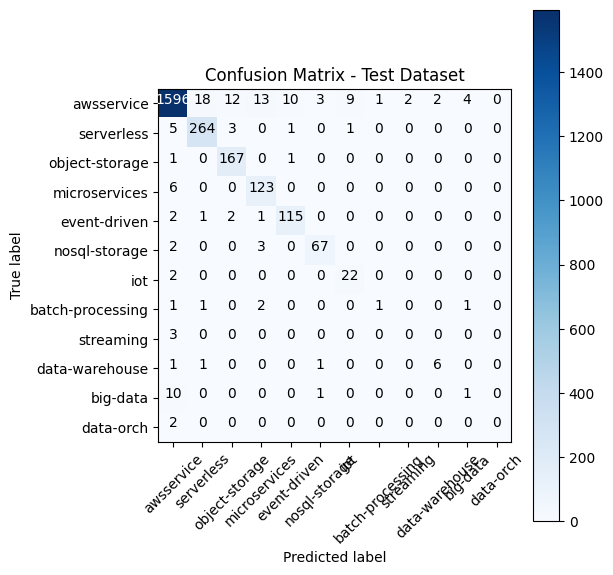

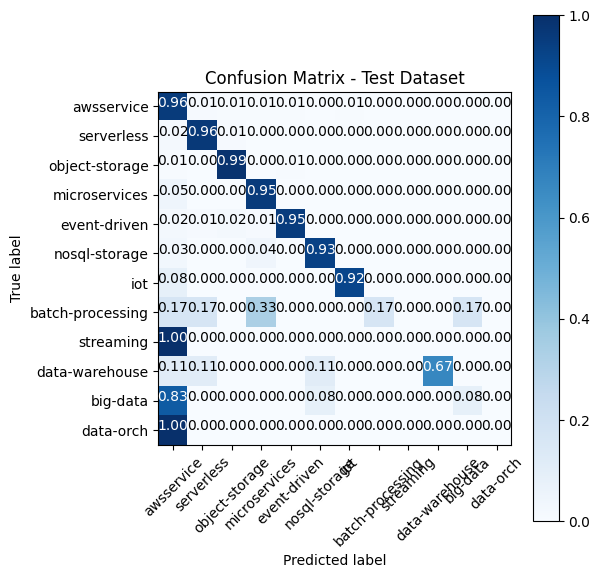

In [104]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix

label_values = [
    'awsservice', 'serverless', 'object-storage', 'microservices', 'event-driven', 'nosql-storage', 'iot', 'batch-processing', 'streaming', 'data-warehouse', 'big-data', 'data-orch'
]
model_names = [
    #("microsoft/codebert-base", "codebert"),

    #("microsoft/unixcoder-base", "unix"),
    ("Salesforce/codet5-base", "codet5"),
    #("roberta-base", "distilbert")
]

for model_n in model_names:
    print("F1 score model", model_n)
    real_values, predictions= calculate_f1_score(model_n[0], model_n[1])
    print(classification_report(real_values, predictions, target_names=label_values))

    cm_test = confusion_matrix(real_values, predictions)

    np.set_printoptions(precision=2)

    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)

In [101]:
 ID_TO_LABEL = {
    0: 'awsservice',
    1: 'serverless',
    2: 'object-storage',
    3: 'microservices',
    4: 'event-driven',
    5: 'nosql-storage',
    6: 'iot',
    7: 'batch-processing',
    10: 'streaming',
    9: 'data-warehouse',
    8: 'big-data',
    11: 'data-orch'
}

In [102]:
import pandas as pd

In [103]:
def load_and_parse_archs():
    paths = [
        # "/Users/lfeliped/pipe/master/experiments/jsonl-validation/go-test.jsonl",
        # "/Users/lfeliped/pipe/master/experiments/jsonl-validation/java-test.jsonl",
        # "/Users/lfeliped/pipe/master/experiments/jsonl-validation/python-test.jsonl",
        # "/Users/lfeliped/pipe/master/experiments/jsonl-validation/typescript-test.jsonl"
        "/Users/lfeliped/pipe/master/experiments/jsonl/test.jsonl",
        "/Users/lfeliped/pipe/master/experiments/jsonl/valid.jsonl",
        "/Users/lfeliped/pipe/master/experiments/jsonl/train.jsonl"
    ]
    count_labels = { i: 0 for i in range(12)}
    d = {"label": [], "code": []}
    for path in paths:
        with open(path) as f:
            for line in f:
                js = json.loads(line.strip())
                count_labels[js['label']]+=1
                d["code"].append(js["code"])
                d["label"].append(js["label"])
    print(count_labels)
    for i in count_labels:
        print(f"{ID_TO_LABEL[i]},{count_labels[i]}")
    return d

dt = load_and_parse_archs()

{0: 22487, 1: 17364, 2: 9672, 3: 5688, 4: 20054, 5: 3861, 6: 706, 7: 139, 8: 216, 9: 192, 10: 157, 11: 48}
awsservice,22487
serverless,17364
object-storage,9672
microservices,5688
event-driven,20054
nosql-storage,3861
iot,706
batch-processing,139
big-data,216
data-warehouse,192
streaming,157
data-orch,48


In [75]:
gola= {
    "serverless": ["awslambda"],
    "microservices": ["awsecs",
                      "awseks",
                      "awsecr"],
    "big-data": ["awsemr",
                 "awsemrcontainers",
                 "awsemrserverless",
                 "awsdlm",
                 "awsdms",
                 ],
    "event-driven": ["awssqs",
                     "awssns",
                     "awsevents"
                     ],
    "batch-processing": ["awsbatch"],
    "iot": ["awsiot"],
    "streaming": ["awskinesis",
                  "awsmsk"
                  ],
    "nosql-storage": ["awsdocdb",
                      "awsdynamodb",
                      "awsdocdbelastic",
                      "awsmemorydb"
                      ],
    "data-warehouse": [
        "awsredshift",
        "awsredshift",
    ],
    "data-orch": [
        "awsdatapipieline",
        "awsdatasync",
    ],
    "object-storage": [
        "awss3",
    ]
}

jala={
    "serverless": ["software.amazon.awscdk.services.lambda"],
    "microservices": ["software.amazon.awscdk.services.ecs",
                      "software.amazon.awscdk.services.eks",
                      "software.amazon.awscdk.services.ecr"],
    "big-data": ["software.amazon.awscdk.services.emr",
                 "software.amazon.awscdk.services.emrcontainers",
                 "software.amazon.awscdk.services.emrserverless",
                 "software.amazon.awscdk.services.dlm",
                 "software.amazon.awscdk.services.dms"],
    "event-driven": ["software.amazon.awscdk.services.sqs",
                     "software.amazon.awscdk.services.sns",
                     "software.amazon.awscdk.services.events"],
    "batch-processing": ["software.amazon.awscdk.services.batch"],
    "iot": ["software.amazon.awscdk.services.iot"],
    "streaming": ["software.amazon.awscdk.services.kinesis",
                  "software.amazon.awscdk.services.msk"],
    "nosql-storage": ["software.amazon.awscdk.services.docdb",
                      "software.amazon.awscdk.services.dynamodb",
                      "software.amazon.awscdk.services.docdbelastic",
                      "software.amazon.awscdk.services.memorydb"],
    "data-warehouse": [
        "software.amazon.awscdk.services.redshift",
    ],
    "data-orch": [
        "software.amazon.awscdk.services.datapipieline",
        "software.amazon.awscdk.services.datasync",
    ],
    "object-storage": [
        "software.amazon.awscdk.services.s3",
    ]
}

tyla = {
    "serverless": ["aws_lambda", "aws-lambda"],
    "microservices": ["aws_ecs",
                      "aws_eks",
                      "aws_eks_legacy",
                      "aws_ecr",
                      "aws-ecs",
                      "aws-eks",
                      "aws-eks-legacy",
                      "aws-ecr"],
    "big-data": ["aws_emr",
                 "aws_emrcontainers",
                 "aws_emrserverless",
                 "aws_dlm",
                 "aws_dms",
                 "aws-emr",
                 "aws-emrcontainers",
                 "aws-emrserverless",
                 "aws-dlm",
                 "aws-dms"
                 ],
    "event-driven": ["aws_sqs",
                     "aws_sns",
                     "aws_events"
                     "aws-sqs",
                     "aws-sns",
                     "aws-events"
                     ],
    "batch-processing": ["aws_batch", "aws-batch"],
    "iot": ["aws_iot", "aws-iot"],
    "streaming": ["aws_kinesis",
                  "aws_msk"
                  "aws-kinesis",
                  "aws-msk"
                  ],
    "nosql-storage": ["aws_docdb",
                      "aws_dynamodb",
                      "aws_docdbelastic",
                      "aws_memorydb"
                      "aws-docdb",
                      "aws-dynamodb",
                      "aws-docdbelastic",
                      "aws-memorydb"
                      ],
    "data-warehouse": [
        "aws_redshift",
        "aws-redshift",
    ],
    "data-orch": [
        "aws_datapipieline",
        "aws_datasync",
        "aws-datapipieline",
        "aws-datasync",
    ],
    "object-storage": [
        "aws_s3",
        "aws-s3",
    ]
}

pyla =  {
    "serverless": ["aws_lambda"],
    "microservices": ["aws_ecs",
                      "aws_eks",
                      "aws_eks_legacy",
                      "aws_ecr"],
    "big-data": ["aws_emr",
                 "aws_emrcontainers",
                 "aws_emrserverless",
                 "aws_dlm",
                 "aws_dms"],
    "event-driven": ["aws_sqs",
                     "aws_sns",
                     "aws_events"],
    "batch-processing": ["aws_batch"],
    "iot": ["aws_iot"],
    "streaming": ["aws_kinesis",
                  "aws_msk"],
    "nosql-storage": ["aws_docdb",
                      "aws_dynamodb",
                      "aws_docdbelastic",
                      "aws_memorydb"],
    "data-warehouse": [
        "aws_redshift",
    ],
    "data-orch": [
        "aws_datapipieline",
        "aws_datasync",
    ],
    "object-storage": [
        "aws_s3",
    ]
}



In [100]:



df = pd.DataFrame(data=dt)

cat3 = df[df["label"] == 0]
print(len(cat3))
for key in tyla:
    criteria = gola[key] + pyla[key] + tyla[key] + jala[key]
    cat4 = cat3[cat3["code"].str.contains("|".join(criteria))]
    print(f"{key}: {len(cat4)}")

22487
serverless: 14
microservices: 184
big-data: 0
event-driven: 45
batch-processing: 2
iot: 3
streaming: 2
nosql-storage: 4
data-warehouse: 0
data-orch: 0
object-storage: 6
